In [ ]:
!pip install gym[atari,accept-rom-license]
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The state space is: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space is: Discrete(3)


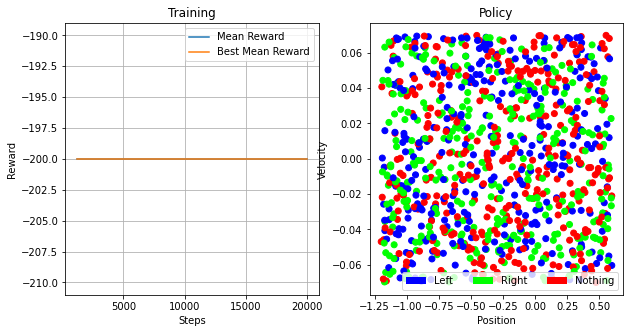

In [ ]:
#Question 1a - MountainCar-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap

def plot(steps,mean_rewards,best_mean_rewards):
    fig = plt.figure(figsize=(10,5)) 
    plt1 = fig.add_subplot(121)
    plt2 = fig.add_subplot(122) 

    plt1.plot(steps,mean_rewards,label='Mean Reward')
    plt1.plot(steps,best_mean_rewards,label='Best Mean Reward')
    plt1.set_title('Training')
    plt1.set_xlabel('Steps')
    plt1.set_ylabel('Reward')
    plt1.grid()
    plt1.legend()

    X = np.random.uniform(-1.2, 0.6, 1000)
    Y = np.random.uniform(-0.07, 0.07, 1000)
    Z = []
    for i in range(len(X)):
        z = random.randrange(3)
        Z.append(z)
    Z = pd.Series(Z)
    colors = {0:'blue',1:'lime',2:'red'}
    colors = Z.apply(lambda x:colors[x])
    labels = ['Left','Right','Nothing']

    plt.set_cmap('brg')
    surf = plt2.scatter(X,Y, c=Z)
    plt2.set_xlabel('Position')
    plt2.set_ylabel('Velocity')
    plt2.set_title('Policy')
    recs = []
    for i in range(0,3):
         recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
    plt2.legend(recs,labels,loc=4,ncol=3)

def select_action(state):
    global steps_done
    steps_done += 1
    return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes, render=False):
    steps = []
    rewards = []
    mean_rewards = []
    
    best_mean_rewards = []
    best_mean_reward = -200.0

    successes = 0
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)
            if render:
                env.render()
            action = action.item()
            obs, reward, done, info = env.step(action)
            next_state =  get_state(obs)
            total_reward += reward

            state = next_state

            if done:
                if obs[0] >= 0.5:
                    successes +=1
                break
        rewards.append(total_reward)
        if episode >= 5:
            steps.append(steps_done)
            mean_reward = np.mean(rewards[-5:])
            mean_rewards.append(mean_reward)
            best_mean_reward = max(mean_reward,best_mean_reward)
            best_mean_rewards.append(best_mean_reward)
        #print('Total steps: {} \t Episode: {}/{} \t Total reward: {} \t Success {}'.format(steps_done, episode, t, total_reward, successes))
    env.close()
    plot(steps,mean_rewards,best_mean_rewards)
    return

# set device
device = torch.device("cpu")
NUM_EPISODES = 100

steps_done = 0

# create environment
env = gym.make('MountainCar-v0')
state_space = env.observation_space
action_space = env.action_space
print("The state space is: {}".format(state_space))
print("The action space is: {}".format(action_space))
    
# train model
train(env, NUM_EPISODES)

The state space is: Box(0, 255, (210, 160, 3), uint8)
The action space is: Discrete(6)


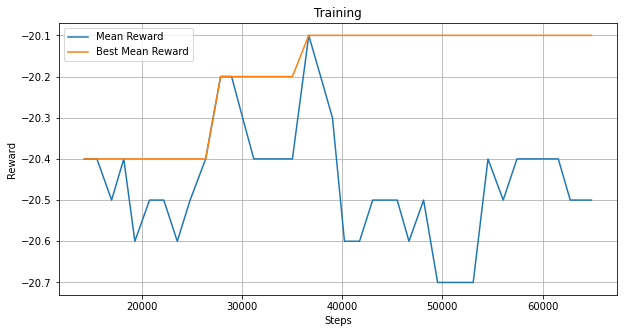

In [ ]:
#Question 1a - Pong-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from PIL import Image
from matplotlib import pyplot as plt

def plot(steps,mean_rewards,best_mean_rewards):
    plt.figure(figsize=(10,5)) 

    plt.plot(steps,mean_rewards,label='Mean Reward')
    plt.plot(steps,best_mean_rewards,label='Best Mean Reward')
    plt.title('Training')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()

def select_action(state):
    global steps_done
    steps_done += 1
    return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)


transform1  =  T.Compose([T.ToPILImage(), T.CenterCrop(160), T.Grayscale()])
transform2 = T.Compose([T.Resize((84,84)),T.ToTensor()])
def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = state.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = transform1(state)
    state =  T.functional.adjust_contrast(state,10)
    state = transform2(state)
    if prev_state is None:
        state = torch.cat([state,state,state],0)
    else:
        state  = torch.cat([prev_state.squeeze(0)[-2:],state],0)
    return state.unsqueeze(0)

action_map = {0:0,1:2,2:3}
def train(env, n_episodes, render=False):
    steps = []
    rewards = []
    mean_rewards = []
    
    best_mean_rewards = []
    best_mean_reward = -21.0
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)
            if render:
                env.render()

            obs, reward, done, info = env.step(action_map[action.item()])

            total_reward += reward

            if not done:
                next_state = get_state(obs, state)
            else:
                next_state = None

            if done:
                break
        rewards.append(total_reward)
        if episode >= 10:
            steps.append(steps_done)
            mean_reward = np.mean(rewards[-10:])
            mean_rewards.append(mean_reward)
            best_mean_reward = max(mean_reward,best_mean_reward)
            best_mean_rewards.append(best_mean_reward)
        #print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'.format(steps_done, episode, t, total_reward))
    plot(steps,mean_rewards,best_mean_rewards)

    env.close()
    return

# set device
device = torch.device("cpu")

NUM_EPISODES = 50

steps_done = 0

# create environment
env = gym.make("Pong-v0")
state_space = env.observation_space
action_space = env.action_space
print("The state space is: {}".format(state_space))
print("The action space is: {}".format(action_space))

# train model
train(env, NUM_EPISODES)

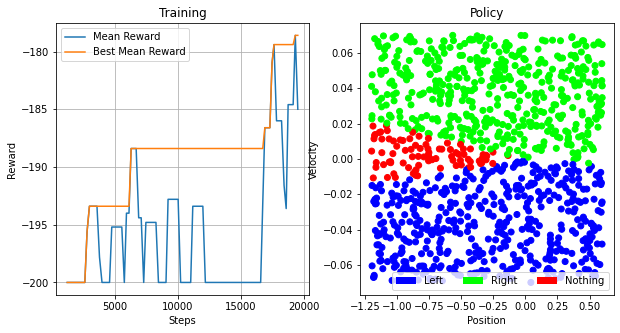

In [ ]:
#Question 1b - MountainCar-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap

def plot(steps,mean_rewards,best_mean_rewards,policy):
    fig = plt.figure(figsize=(10,5)) 
    plt1 = fig.add_subplot(121)
    plt2 = fig.add_subplot(122) 

    plt1.plot(steps,mean_rewards,label='Mean Reward')
    plt1.plot(steps,best_mean_rewards,label='Best Mean Reward')
    plt1.set_title('Training')
    plt1.set_xlabel('Steps')
    plt1.set_ylabel('Reward')
    plt1.grid()
    plt1.legend()

    X = np.random.uniform(-1.2, 0.6, 1000)
    Y = np.random.uniform(-0.07, 0.07, 1000)
    Z = []
    for i in range(len(X)):
        _, temp = torch.max(policy(torch.from_numpy(np.array([X[i],Y[i]])).type(torch.FloatTensor)), dim =-1)
        z = temp.item()
        Z.append(z)
    Z = pd.Series(Z)
    colors = {0:'blue',1:'lime',2:'red'}
    colors = Z.apply(lambda x:colors[x])
    labels = ['Left','Right','Nothing']

    plt.set_cmap('brg')
    surf = plt2.scatter(X,Y, c=Z)
    plt2.set_xlabel('Position')
    plt2.set_ylabel('Velocity')
    plt2.set_title('Policy')
    recs = []
    for i in range(0,3):
         recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
    plt2.legend(recs,labels,loc=4,ncol=3)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class DQN(nn.Module):
    def __init__(self):

        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2, 200,bias=False)
        self.fc2 = nn.Linear(200, 3,bias=False)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

Transition = namedtuple('Transion', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END)* \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

    
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    for index in range(100):
        transitions = memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        actions = tuple((map(lambda a: torch.tensor([[a]], device=device), batch.action))) 
        rewards = tuple((map(lambda r: torch.tensor([r], device=device), batch.reward))) 

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),device=device, dtype=torch.bool)
        
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(actions)
        reward_batch = torch.cat(rewards)
        
        state_action_values = policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(BATCH_SIZE, device=device)

        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        loss = F.mse_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())
        
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes, render=False):
    steps = []
    rewards = []
    mean_rewards = []
    
    best_mean_rewards = []
    best_mean_reward = -200.0

    successes = 0
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)

            if render:
                env.render()
            action = action.item()
            obs, reward, done, info = env.step(action)
            
            total_reward += reward

            reward = obs[0] + 0.5
            if obs[0] >= 0.5:
                reward += 1.0
            

            if not done:
                next_state = get_state(obs, state)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action, next_state, reward.to('cpu'))
            state = next_state

            if steps_done > INITIAL_MEMORY:
                optimize_model()

            if done:
                if obs[0] >= 0.5:
                    successes +=1
                break
        if (episode+1) % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        rewards.append(total_reward)
        if episode >= 5:
            steps.append(steps_done)
            mean_reward = np.mean(rewards[-5:])
            mean_rewards.append(mean_reward)
            best_mean_reward = max(mean_reward,best_mean_reward)
            best_mean_rewards.append(best_mean_reward)
        #print('Total steps: {} \t Episode: {}/{} \t Total reward: {} \t Success {}'.format(steps_done, episode, t, total_reward, successes))
    env.close()
    d = {'steps':steps, 'mean_rewards': mean_rewards, 'best_mean_rewards':best_mean_rewards}
    np.save('./dqn8_results.npy',d)
    plot(steps,mean_rewards,best_mean_rewards,policy_net)
    return

# set device
device = torch.device("cpu")

# hyperparameters
BATCH_SIZE = 8
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 1000
TARGET_UPDATE = 5
INITIAL_MEMORY = 1000
MEMORY_SIZE = 1*INITIAL_MEMORY
NUM_EPISODES = 100

# create networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

# setup optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

steps_done = 0

# create environment
env = gym.make('MountainCar-v0')

# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)
    
# train model
train(env, NUM_EPISODES)

torch.save(policy_net, "./dqn_mc.pt")

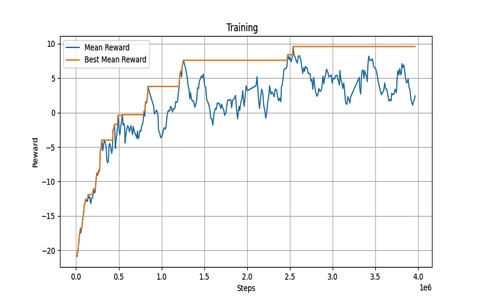

In [ ]:
#Question 1b - Pong-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from collections import namedtuple
import random
from PIL import Image
from matplotlib import pyplot as plt

def plot(steps,mean_rewards,best_mean_rewards):
    plt.figure(figsize=(6,4)) 

    plt.plot(steps,mean_rewards,label='Mean Reward')
    plt.plot(steps,best_mean_rewards,label='Best Mean Reward')
    plt.title('Training')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()

class DQN(nn.Module):
    def __init__(self, in_channels=3, n_actions=3):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.head = nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

Transition = namedtuple('Transion', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END)* \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

    
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    for _ in range(1):
        transitions = memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        actions = tuple((map(lambda a: torch.tensor([[a]], device=device), batch.action))) 
        rewards = tuple((map(lambda r: torch.tensor([r], device=device), batch.reward))) 

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),device=device, dtype=torch.bool)
        
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
        
        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(actions)
        reward_batch = torch.cat(rewards)
        
        state_action_values = policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        loss = F.mse_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

transform1  =  T.Compose([T.ToPILImage(), T.CenterCrop(160), T.Grayscale()])
transform2 = T.Compose([T.Resize((84,84)),T.ToTensor()])
def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = state.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = transform1(state)
    state =  T.functional.adjust_contrast(state,10)
    state = transform2(state)
    if prev_state is None:
        state = torch.cat([state,state,state],0)
    else:
        state  = torch.cat([prev_state.squeeze(0)[-2:],state],0)
    return state.unsqueeze(0)

action_map = {0:0,1:2,2:3}
def train(env, n_episodes, render=False):
    steps = []
    rewards = []
    mean_rewards = []
    
    best_mean_rewards = []
    best_mean_reward = -21.0
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)
            if render:
                env.render()

            obs, reward, done, info = env.step(action_map[action.item()])

            total_reward += reward

            if not done:
                next_state = get_state(obs, state)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
            state = next_state

            if steps_done > INITIAL_MEMORY:
                optimize_model()
            
            if (steps_done+1) % TARGET_UPDATE == 0:
              target_net.load_state_dict(policy_net.state_dict())

            if done:
                break
        rewards.append(total_reward)
        if episode >= 10:
            steps.append(steps_done)
            mean_reward = np.mean(rewards[-10:])
            mean_rewards.append(mean_reward)
            best_mean_reward = max(mean_reward,best_mean_reward)
            best_mean_rewards.append(best_mean_reward)
        #print('Total steps: {} \t Episode: {}/{} \t Total reward: {}'.format(steps_done, episode, t, total_reward))
        d = {'steps':steps, 'mean_rewards': mean_rewards, 'best_mean_rewards':best_mean_rewards}
        np.save('dqn_results.npy',d)
        torch.save(policy_net, "dqn_pong.pt")
        torch.save(target_net, "dqn_pong_t.pt")

    plot(steps,mean_rewards,best_mean_rewards)
    env.close()
    return

# set device
device = torch.device("cpu")

# hyperparameters
BATCH_SIZE = 32
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 25000
TARGET_UPDATE = 1000
INITIAL_MEMORY = 1000
MEMORY_SIZE = 20* INITIAL_MEMORY
NUM_EPISODES = 2000

# create networks
policy_net = DQN(n_actions=3).to(device)
target_net = DQN(n_actions=3).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(),lr=0.0001)
steps_done = 0

# create environment
env = gym.make('Pong-v0')

# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)
    
# train model
train(env, NUM_EPISODES)

In [ ]:
#Question 1c - MountainCar-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class DQN(nn.Module):
    def __init__(self):

        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2, 200,bias=False)
        self.fc2 = nn.Linear(200, 3,bias=False)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

Transition = namedtuple('Transion', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END)* \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

    
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    for index in range(100):
        transitions = memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        actions = tuple((map(lambda a: torch.tensor([[a]], device=device), batch.action))) 
        rewards = tuple((map(lambda r: torch.tensor([r], device=device), batch.reward))) 

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),device=device, dtype=torch.bool)
        
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(actions)
        reward_batch = torch.cat(rewards)
        
        state_action_values = policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(BATCH_SIZE, device=device)

        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        loss = F.mse_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())
        
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes, render=False):
    steps = []
    rewards = []
    mean_rewards = []
    
    best_mean_rewards = []
    best_mean_reward = -200.0

    successes = 0
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        # print(state.shape)
        total_reward = 0.0
        for t in count():
            action = select_action(state)

            if render:
                env.render()
            action = action.item()
            obs, reward, done, info = env.step(action)
            
            total_reward += reward

            reward = obs[0] + 0.5
            if obs[0] >= 0.5:
                reward += 1.0
            

            if not done:
                next_state = get_state(obs, state)
            else:
                next_state = None

            reward = torch.tensor([reward], device=device)

            memory.push(state, action, next_state, reward.to('cpu'))
            state = next_state

            if steps_done > INITIAL_MEMORY:
                optimize_model()

            if done:
                if obs[0] >= 0.5:
                    successes +=1
                break
        if (episode+1) % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        rewards.append(total_reward)
        if episode >= 5:
            steps.append(steps_done)
            mean_reward = np.mean(rewards[-5:])
            mean_rewards.append(mean_reward)
            best_mean_reward = max(mean_reward,best_mean_reward)
            best_mean_rewards.append(best_mean_reward)
        #print('Total steps: {} \t Episode: {}/{} \t Total reward: {} \t Success {}'.format(steps_done, episode, t, total_reward, successes))
    env.close()
    d = {'steps':steps, 'mean_rewards': mean_rewards, 'best_mean_rewards':best_mean_rewards}
    np.save('./dqn8_results.npy',d)
    return [steps,mean_rewards]

BATCH_SIZE_list = [8,16,32,64]
Results = []

for i in range(4):
  # set device
  device = torch.device("cpu")

  # hyperparameters
  BATCH_SIZE = BATCH_SIZE_list[i]
  GAMMA = 0.9
  EPS_START = 1.0
  EPS_END = 0.02
  EPS_DECAY = 1000
  TARGET_UPDATE = 5
  INITIAL_MEMORY = 1000
  MEMORY_SIZE = 1* INITIAL_MEMORY
  NUM_EPISODES = 100
  # create networks
  policy_net = DQN().to(device)
  # policy_net.apply(weights_init)
  target_net = DQN().to(device)
  target_net.load_state_dict(policy_net.state_dict())

  # setup optimizer
  optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

  steps_done = 0

  # create environment
  env = gym.make('MountainCar-v0')

  # initialize replay memory
  memory = ReplayMemory(MEMORY_SIZE)
    
  # train model
  Result = train(env, NUM_EPISODES)
  Results.append(Result)
  torch.save(policy_net, "./dqn_mc.pt")

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


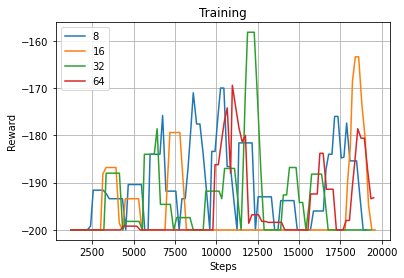

In [ ]:
#Question 1c - MountainCar-v0

BATCH_SIZE_list = [8,16,32,64]

Results = np.array(Results)

for i in range(len(Results)):
  plt.plot(Results[i,0],Results[i,1],label=BATCH_SIZE_list[i])

plt.title('Training')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

The state space is: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
The action space is: Discrete(2)


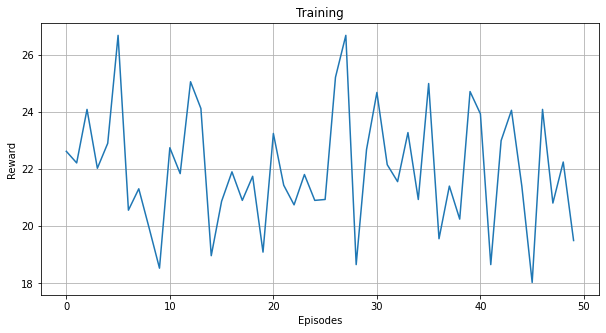

In [ ]:
#Question 2a - Cartpole-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

from PIL import Image
from matplotlib import pyplot as plt

def plot(rewards):
    plt.figure(figsize=(10,5)) 

    plt.plot(rewards,label='Mean Reward')
    plt.title('Training')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.grid()

def select_action(state):
    return random.randrange(0,env.action_space.n)
    
def get_state(obs):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env):
    rewards = []

    for epoch in range(ITERATIONS):
        episode_rewards_batch = []
        for episode in range(BATCH_SIZE):
            obs = env.reset()
            state = get_state(obs)
            episode_rewards = []
            policy_history = []
            total_reward = 0.0
            for t in count():
                action= select_action(state)
                obs, reward, done, info = env.step(action)
                state  =  get_state(obs)
                episode_rewards.append(reward)

                if done:
                    break
            episode_rewards_batch.append(episode_rewards)
        rewards.append(np.mean([np.sum(er) for er in episode_rewards_batch]))
        #print('Iteration: {} \t Total reward: {}'.format(epoch,rewards[-1]))  
        
    env.close()
    plot(rewards)
    return

# set device
device = torch.device("cpu")

ITERATIONS = 50
BATCH_SIZE = 32
env = gym.make('CartPole-v0')
state_space = env.observation_space
action_space = env.action_space
print("The state space is: {}".format(state_space))
print("The action space is: {}".format(action_space))

train(env)

The state space is: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
The action space is: Discrete(4)


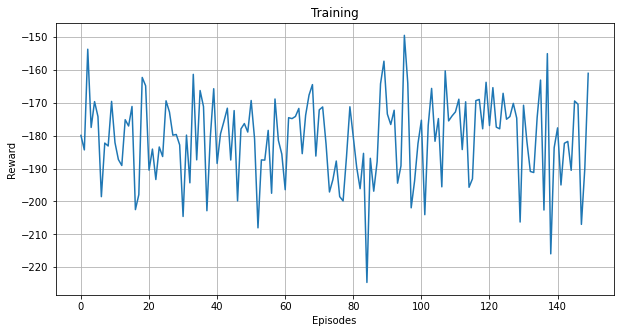

In [ ]:
#Question 2a - Lunarlander-v2

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

from PIL import Image
from matplotlib import pyplot as plt

def plot(rewards):
    plt.figure(figsize=(10,5)) 

    plt.plot(rewards,label='Mean Reward')
    plt.title('Training')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.grid()

def select_action(state):
    return random.randrange(0,env.action_space.n)
    
def get_state(obs):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env):
    rewards = []

    for epoch in range(ITERATIONS):
        episode_rewards_batch = []
        for episode in range(BATCH_SIZE):
            obs = env.reset()
            state = get_state(obs)
            episode_rewards = []
            policy_history = []
            total_reward = 0.0
            for t in count():
                action= select_action(state)
                obs, reward, done, info = env.step(action)
                state  =  get_state(obs)
                episode_rewards.append(reward)

                if done:
                    break
            episode_rewards_batch.append(episode_rewards)
        rewards.append(np.mean([np.sum(er) for er in episode_rewards_batch]))
        #print('Iteration: {} \t Total reward: {}'.format(epoch,rewards[-1]))  
        
    env.close()
    plot(rewards)
    return

# set device
device = torch.device("cpu")

ITERATIONS = 150
BATCH_SIZE = 64
env = gym.make('LunarLander-v2')
state_space = env.observation_space
action_space = env.action_space
print("The state space is: {}".format(state_space))
print("The action space is: {}".format(action_space))

train(env)

In [ ]:
#Question 2b - Cartpole-v0
#I have included Q2b-Cartpole.py file in the zip file that I have submitted

!python3 Q2b-Cartpole.py --env="CartPole-v0" --iterations=50 --batch=32 --gamma=0.9 --lr=0.01

!python3 Q2b-Cartpole.py --env="CartPole-v0" --reward_to_go --iterations=50 --batch=32 --gamma=0.9 --lr=0.01

!python3 Q2b-Cartpole.py --env="CartPole-v0" --reward_to_go --adv_norm --iterations=50 --batch=32 --gamma=0.9 --lr=0.01

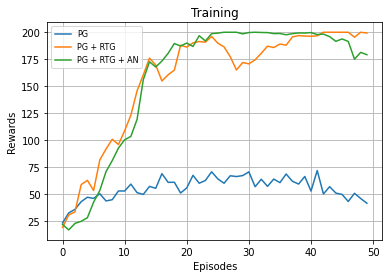

In [ ]:
#Question 2b - Cartpole-v0

import numpy as np
from matplotlib import pyplot as plt

CartPole = np.load('CartPole-v0_32.npy')
CartPole_rtg = np.load('CartPole-v0_32_rtg.npy')
CartPole_rtg_adv_norm = np.load('CartPole-v0_32_rtg_adv_norm.npy')
episodes = np.arange(50)

#Plotting
plt.plot(episodes,CartPole,label='PG')
plt.plot(episodes,CartPole_rtg,label='PG + RTG')
plt.plot(episodes,CartPole_rtg_adv_norm,label='PG + RTG + AN')
plt.legend(prop={'size': 8})
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Training')
plt.grid()
plt.show()

In [ ]:
#Question 2b - Lunarlander-v2
#I have included Q2b-Lunarlander.py file in the zip file that I have submitted

!python3 Q2b-Lunarlander.py --env="LunarLander-v2" --iterations=50 --batch=32 --gamma=0.99 --lr=0.005

!python3 Q2b-Lunarlander.py --env="LunarLander-v2" --reward_to_go --iterations=50 --batch=32 --gamma=0.99 --lr=0.005

!python3 Q2b-Lunarlander.py --env="LunarLander-v2" --reward_to_go --adv_norm --iterations=50 --batch=32 --gamma=0.99 --lr=0.005

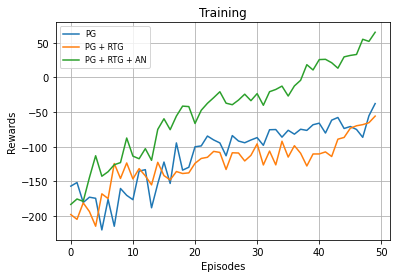

In [ ]:
#Question 2b - Lunarlander-v2

import numpy as np
from matplotlib import pyplot as plt

LunarLander = np.load('LunarLander-v2_32.npy')
LunarLander_rtg = np.load('LunarLander-v2_32_rtg.npy')
LunarLander_rtg_adv_norm = np.load('LunarLander-v2_32_rtg_adv_norm.npy')
episodes = np.arange(50)

#Plotting
plt.plot(episodes,LunarLander,label='PG')
plt.plot(episodes,LunarLander_rtg,label='PG + RTG')
plt.plot(episodes,LunarLander_rtg_adv_norm,label='PG + RTG + AN')
plt.legend(prop={'size': 8})
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Training')
plt.grid()
plt.show()

In [ ]:
#Question 2c - Cartpole-v0

!python3 Q2b-Cartpole.py --env="CartPole-v0" --reward_to_go --adv_norm --iterations=50 --batch=8 --gamma=0.9 --lr=0.01

!python3 Q2b-Cartpole.py --env="CartPole-v0" --reward_to_go --adv_norm --iterations=50 --batch=16 --gamma=0.9 --lr=0.01

!python3 Q2b-Cartpole.py --env="CartPole-v0" --reward_to_go --adv_norm --iterations=50 --batch=32 --gamma=0.9 --lr=0.01

!python3 Q2b-Cartpole.py --env="CartPole-v0" --reward_to_go --adv_norm --iterations=50 --batch=64 --gamma=0.9 --lr=0.01

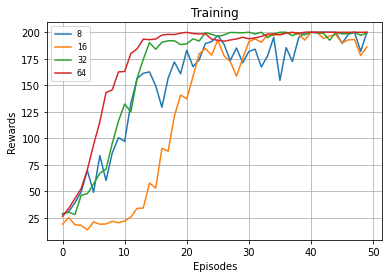

In [ ]:
#Question 2c - Cartpole-v0

import numpy as np
from matplotlib import pyplot as plt

CartPole_8 = np.load('CartPole-v0_8_rtg_adv_norm.npy')
CartPole_16 = np.load('CartPole-v0_16_rtg_adv_norm.npy')
CartPole_32 = np.load('CartPole-v0_32_rtg_adv_norm.npy')
CartPole_64 = np.load('CartPole-v0_64_rtg_adv_norm.npy')
episodes = np.arange(50)

#Plotting
plt.plot(episodes,CartPole_8,label='8')
plt.plot(episodes,CartPole_16,label='16')
plt.plot(episodes,CartPole_32,label='32')
plt.plot(episodes,CartPole_64,label='64')
plt.legend(prop={'size': 8})
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Training')
plt.grid()
plt.show()

In [ ]:
#Question 2c - Lunarlander-v2

!python3 Q2b-Lunarlander.py --env="LunarLander-v2" --reward_to_go --adv_norm --iterations=50 --batch=8 --gamma=0.99 --lr=0.005

!python3 Q2b-Lunarlander.py --env="LunarLander-v2" --reward_to_go --adv_norm --iterations=50 --batch=16 --gamma=0.99 --lr=0.005

!python3 Q2b-Lunarlander.py --env="LunarLander-v2" --reward_to_go --adv_norm --iterations=50 --batch=32 --gamma=0.99 --lr=0.005

!python3 Q2b-Lunarlander.py --env="LunarLander-v2" --reward_to_go --adv_norm --iterations=50 --batch=64 --gamma=0.99 --lr=0.005

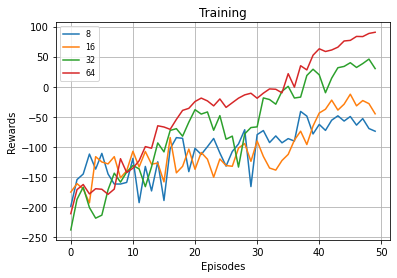

In [ ]:
#Question 2c - Lunarlander-v2

import numpy as np
from matplotlib import pyplot as plt

LunarLander_8 = np.load('LunarLander-v2_8_rtg_adv_norm.npy')
LunarLander_16 = np.load('LunarLander-v2_16_rtg_adv_norm.npy')
LunarLander_32 = np.load('LunarLander-v2_32_rtg_adv_norm.npy')
LunarLander_64 = np.load('LunarLander-v2_64_rtg_adv_norm.npy')
episodes = np.arange(50)

#Plotting
plt.plot(episodes,LunarLander_8,label='8')
plt.plot(episodes,LunarLander_16,label='16')
plt.plot(episodes,LunarLander_32,label='32')
plt.plot(episodes,LunarLander_64,label='64')
plt.legend(prop={'size': 8})
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Training')
plt.grid()
plt.show()

Question 2c

We can make the following inferences about the impact of batch size on the policy gradient estimates from above plots :
- **Cartpole-v0** : The rewards obtained for all the batch sizes i.e; 8,16,32 and 64 increase (on an average) as the number of episodes/iterations increase and finally converge to values which are very close to each other.
- **Lunarlander-v2** : The rewards obtained for the batch sizes i.e; 8,16,32 and 64 increase (on an average) as the number of episodes/iterations increase and finally converge to different values. The final reward value that the curves converge to is directly proportional to their corresponding batch size.


